# From Python to egglog and Back Again

_Presented by Saul at the [EGRAPHS community calls lightning talk on 3/21/24](https://egraphs.org/meeting/2024-03-21-lightning-talks)_


_Now that I have this great e-graph library in Python, what extra mechanisms do I need to make it useful in existing Python code?_

_This talk will go thorugh a few techniques developed and also point to how by bringing in use cases from scientific Python can help drive further theoretic research_

TODO: Imperative vs functional
![](./Untitled.svg)


## Optimizing Scikit-learn with Numba

_We are going to work through the different pieces needed to optimize a Scikit-learn pipeline using Numba and egglog._

This works as a test case, if sklearn thinks your thing is a ndarray array then also users can trust that it works like that too.


In [1]:
from __future__ import annotations

import sklearn
from sklearn.datasets import make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Tell sklearn to treat arrays as following array API
sklearn.set_config(array_api_dispatch=True)

X_np, y_np = make_classification(random_state=0, n_samples=1000000)


# Assumption: I want to optimize calling this many times on data similar to that above
def run_lda(x, y):
    lda = LinearDiscriminantAnalysis()
    return lda.fit(x, y).transform(x)

We can do this using egglog to generate Python code and Numba to JIT compile it to LLVM, resulting in a speedup:

![](https://egglog-python.readthedocs.io/latest/_images/0662bf9dd34caffce5ae8be1110d6b58d82419765f5373441c528a88985e8a28.png)


In [2]:
# The first thing we need to do is create our symbolic arrays and get back our symbolic output

from egglog.exp.array_api import *

X_arr = NDArray.var("X")
assume_dtype(X_arr, X_np.dtype)
assume_shape(X_arr, X_np.shape)
assume_isfinite(X_arr)

y_arr = NDArray.var("y")
assume_dtype(y_arr, y_np.dtype)
assume_shape(y_arr, y_np.shape)
assume_value_one_of(y_arr, tuple(map(int, np.unique(y_np))))  # type: ignore[arg-type]

with EGraph():
    res = run_lda(X_arr, y_arr)

COMPUTING PRIORS!


In [3]:
res

_NDArray_1 = NDArray.var("X")
assume_dtype(_NDArray_1, DType.float64)
assume_shape(_NDArray_1, TupleInt(Int(1000000)) + TupleInt(Int(20)))
assume_isfinite(_NDArray_1)
_NDArray_2 = NDArray.var("y")
assume_dtype(_NDArray_2, DType.int64)
assume_shape(_NDArray_2, TupleInt(Int(1000000)))
assume_value_one_of(_NDArray_2, TupleValue(Value.int(Int(0))) + TupleValue(Value.int(Int(1))))
_NDArray_3 = asarray(reshape(asarray(_NDArray_2), TupleInt(Int(-1))))
_NDArray_4 = astype(unique_counts(_NDArray_3)[Int(1)], asarray(_NDArray_1).dtype) / NDArray.scalar(Value.float(Float(1000000.0)))
_NDArray_5 = zeros(
    TupleInt(unique_inverse(_NDArray_3)[Int(0)].shape[Int(0)]) + TupleInt(asarray(_NDArray_1).shape[Int(1)]),
    OptionalDType.some(asarray(_NDArray_1).dtype),
    OptionalDevice.some(asarray(_NDArray_1).device),
)
_MultiAxisIndexKey_1 = MultiAxisIndexKey(MultiAxisIndexKeyItem.slice(Slice()))
_IndexKey_1 = IndexKey.multi_axis(MultiAxisIndexKey(MultiAxisIndexKeyItem.int(Int(0))) + _MultiAxisIndexKey_1)
_OptionalIntOrTuple_1 = OptionalIntOrTuple.some(IntOrTuple.int(Int(0)))
_NDArray_5[_IndexKey_1] = mean(asarray(_NDArray_1)[ndarray_index(unique_inverse(_NDArray_3)[Int(1)] == NDArray.scalar(Value.int(Int(0))))], _OptionalIntOrTuple_1)
_IndexKey_2 = IndexKey.multi_axis(MultiAxisIndexKey(MultiAxisIndexKeyItem.int(Int(1))) + _MultiAxisIndexKey_1)
_NDArray_5[_IndexKey_2] = mean(asarray(_NDArray_1)[ndarray_index(unique_inverse(_NDArray_3)[Int(1)] == NDArray.scalar(Value.int(Int(1))))], _OptionalIntOrTuple_1)
_NDArray_6 = unique_values(concat(TupleNDArray(unique_values(asarray(_NDArray_3)))))
_NDArray_7 = concat(
    TupleNDArray(asarray(_NDArray_1)[ndarray_index(_NDArray_3 == _NDArray_6[IndexKey.int(Int(0))])] - _NDArray_5[_IndexKey_1])
    + TupleNDArray(asarray(_NDArray_1)[ndarray_index(_NDArray_3 == _NDArray_6[IndexKey.int(Int(1))])] - _NDArray_5[_IndexKey_2]),
    OptionalInt.some(Int(0)),
)
_NDArray_8 = std(_NDArray_7, _OptionalIntOrTuple_1)
_NDArray_8[ndarray_index(std(_NDArray_7, _OptionalIntOrTuple_1) == NDArray.scalar(Value.int(Int(0))))] = NDArray.scalar(Value.float(Float(1.0)))
_TupleNDArray_1 = svd(
    sqrt(asarray(NDArray.scalar(Value.float(Float(1.0) / Float.from_int(asarray(_NDArray_1).shape[Int(0)] - _NDArray_6.shape[Int(0)]))))) * (_NDArray_7 / _NDArray_8), FALSE
)
_Slice_1 = Slice(OptionalInt.none, OptionalInt.some(sum(astype(_TupleNDArray_1[Int(1)] > NDArray.scalar(Value.float(Float(0.0001))), DType.int32)).to_value().to_int))
_NDArray_9 = (_TupleNDArray_1[Int(2)][IndexKey.multi_axis(MultiAxisIndexKey(MultiAxisIndexKeyItem.slice(_Slice_1)) + _MultiAxisIndexKey_1)] / _NDArray_8).T / _TupleNDArray_1[
    Int(1)
][IndexKey.slice(_Slice_1)]
_TupleNDArray_2 = svd(
    (
        sqrt(
            (NDArray.scalar(Value.int(asarray(_NDArray_1).shape[Int(0)])) * _NDArray_4)
            * NDArray.scalar(Value.float(Float(1.0) / Float.from_int(_NDArray_6.shape[Int(0)] - Int(1))))
        )
        * (_NDArray_5 - (_NDArray_4 @ _NDArray_5)).T
    ).T
    @ _NDArray_9,
    FALSE,
)
(
    (asarray(_NDArray_1) - (_NDArray_4 @ _NDArray_5))
    @ (
        _NDArray_9
        @ _TupleNDArray_2[Int(2)].T[
            IndexKey.multi_axis(
                _MultiAxisIndexKey_1
                + MultiAxisIndexKey(
                    MultiAxisIndexKeyItem.slice(
                        Slice(
                            OptionalInt.none,
                            OptionalInt.some(
                                sum(astype(_TupleNDArray_2[Int(1)] > (NDArray.scalar(Value.float(Float(0.0001))) * _TupleNDArray_2[Int(1)][IndexKey.int(Int(0))]), DType.int32))
                                .to_value()
                                .to_int
                            ),
                        )
                    )
                )
            )
        ]
    )
)[IndexKey.multi_axis(_MultiAxisIndexKey_1 + MultiAxisIndexKey(MultiAxisIndexKeyItem.slice(Slice(OptionalInt.none, OptionalInt.some(_NDArray_6.shape[Int(0)] - Int(1))))))]

In order to run this, scikit-learn treated these objects as "array like", meaning they conformed to [the Array API](https://data-apis.org/array-api/latest/).


## Conversions: From Python to egglog

_Use conversions if you want your egglog API to be called with existing Python objects, without manually upcasting them_

_We will see this in our example:_


```python
class LinearDiscriminantAnalysis:
    ...
    def fit(self, X, y):
        ...
        _, cnts = xp.unique_counts(y)  # non-negative ints
        self.priors_ = xp.astype(cnts, X.dtype) / float(y.shape[0])
```

Ends up resulting in this expression:

```python
astype(unique_counts(_NDArray_3)[Int(1)], asarray(_NDArray_1).dtype) / NDArray.scalar(Value.float(Float(1000000.0)))
```


How?

We have exposed a global conversion logic, where if you pass an arg to egglog and it isn't the correct type, it will try to upcast the arg to the required egglog type.

There is a graph of all conversions and it will find the shortest path from the input to the desired type and automatically upcast to that.

For example, in indexing, if we do a slice (i.e. `1:10:2`), we convert this to our custom egglog `Slice` expressions:


In [4]:
class Slice(Expr):
    def __init__(
        self,
        start: OptionalInt = OptionalInt.none,
        stop: OptionalInt = OptionalInt.none,
        step: OptionalInt = OptionalInt.none,
    ) -> None: ...


converter(
    slice,
    Slice,
    lambda x: Slice(
        convert(x.start, OptionalInt),
        convert(x.stop, OptionalInt),
        convert(x.step, OptionalInt),
    ),
)

In [5]:
class A(Expr):
    def __init__(self) -> None: ...
    def __getitem__(self, s: Slice) -> Int: ...

In [6]:
A()[:1:2]  # Pytohn desugars this to A()[slice(None, 1, 2)]

A()[Slice(OptionalInt.none, OptionalInt.some(Int(1)), OptionalInt.some(Int(2)))]

## Preserved Methods

_If you need your egglog objects to interact with Python control flow, you can use preserved methods to stop, compile, and return an eager result to Python_


In the `fit` function in sklearn, there are complicated analysis that must be done eagerly, like this one, which
depends on knowing the priors, which are based on the counts of the classes in the training data, which we provided:

```python
class LinearDiscriminantAnalysis:
    def fit(self, x, y):
        ...
        if xp.abs(xp.sum(self.priors_) - 1.0) > 1e-5:
            warnings.warn("The priors do not sum to 1. Renormalizing", UserWarning)
            self.priors_ = self.priors_ / self.priors_.sum()
```

That is why we have to provide the metadata about the arrays, so we can reduce this expression to a boolean, using some interval analysis:

```python
_NDArray_1 = NDArray.var("y")
assume_dtype(_NDArray_1, DType.int64)
assume_shape(_NDArray_1, TupleInt(Int(1000000)))
assume_value_one_of(_NDArray_1, TupleValue(Value.int(Int(0))) + TupleValue(Value.int(Int(1))))
_NDArray_2 = NDArray.var("X")
assume_dtype(_NDArray_2, DType.float64)
assume_shape(_NDArray_2, TupleInt(Int(1000000)) + TupleInt(Int(20)))
assume_isfinite(_NDArray_2)
(
    abs(
        sum(astype(unique_counts(asarray(reshape(asarray(_NDArray_1), TupleInt(Int(-1)))))[Int(1)], asarray(_NDArray_2).dtype) / NDArray.scalar(Value.float(Float(1000000.0))))
        - NDArray.scalar(Value.float(Float(1.0)))
    )
    > NDArray.scalar(Value.float(Float(1e-05)))
).to_value().to_bool.bool
```


But how does it move through the control flow if the expression is lazy? We can implement "preserved methods" which can evaluate an expression eagerly by adding it to the EGraph and evalutating it:


### Example


In [7]:
class Boolean(Expr):
    # Can be constructed from and convert to a primitive egglog bool:
    def __init__(self, b: BoolLike) -> None: ...
    @property
    def bool(self) -> Bool: ...

    # support boolean ops
    def __and__(self, other: Boolean) -> Boolean: ...

    # Can be treated like a Python bool
    @method(preserve=True)
    def __bool__(self) -> bool:
        egraph = EGraph()
        egraph.register(self)
        egraph.run(bool_rewrites.saturate())
        return egraph.eval(self.bool)


x = var("x", Boolean)
y = var("y", Bool)
bool_rewrites = ruleset(
    rule(eq(x).to(Boolean(y))).then(set_(x.bool).to(y)),
    rewrite(Boolean(True) & Boolean(True)).to(Boolean(True)),
)

expr = Boolean(True) & Boolean(True)
expr

Boolean(True) & Boolean(True)

In [8]:
if expr:
    print("yep it's true")

yep it's true


## Mutations

_Mark a function or method as mutating the first arg, to translate it to pure function, but which acts imperative._

Another pattern that comes up a lot in Python is methods that mutate their arguments. But egglog is a pure functional language, so how do we support that?

Well we can convert functions that mutate an arg into one that returns a modified value of that argument. That way, we can keep
using it with existing imperative methods and things work as they should.

For example, arrays support `__setitem__`, and this is used by scikit-learn:

```python
class LinearDiscriminantAnalysis:
    ...
    def _solve_svd(self, X, y):
        ...
        # 1) within (univariate) scaling by with classes std-dev
        std = xp.std(Xc, axis=0)
        # avoid division by zero in normalization
        std[std == 0] = 1.0
```

This will be translated to the following expressions, where there will be a new array created in the graph for the modified version:

```python
_NDArray_8 = std(_NDArray_7, _OptionalIntOrTuple_1)
_NDArray_8[ndarray_index(std(_NDArray_7, _OptionalIntOrTuple_1) == NDArray.scalar(Value.int(Int(0))))] = NDArray.scalar(Value.float(Float(1.0)))
```


### Example

We can see a simpler example of this below:


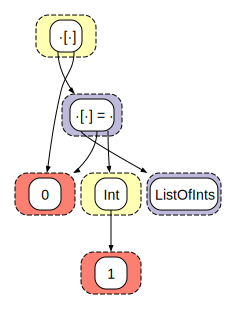

In [11]:
class ListOfInts(Expr):
    def __init__(self) -> None: ...
    def __getitem__(self, i: i64Like) -> Int: ...

    def __setitem__(self, i: i64Like, v: Int) -> None: ...


xs = ListOfInts()
xs[0] = Int(1)

egraph = EGraph()
egraph.register(xs[0])
egraph.display()

## Subsumption

Now that we have a program, what do we do with it? Well first, we can optimize it, running rewrites, including those to translate from Numba forms to others.

We have added "subsumption" to egglog, to support directional rewrites, so that the left hand side is not extractable and not matchable.
This is handy when we want to extract a value with more expressions or a higher cost, in a particular instance:

```python
@array_api_numba_ruleset.register
def _mean(y: NDArray, x: NDArray, i: Int):
    axis = OptionalIntOrTuple.some(IntOrTuple.int(i))
    res = sum(x, axis) / NDArray.scalar(Value.int(x.shape[i]))

    yield rewrite(mean(x, axis, FALSE), subsume=True).to(res)
    yield rewrite(mean(x, axis, TRUE), subsume=True).to(expand_dims(res, i))
```


We can optimize this with the numba rules and we can see this rule take place in the `_NDArray_9` line:


In [13]:
from egglog.exp.array_api_numba import array_api_numba_schedule

simplified_res = EGraph().simplify(res, array_api_numba_schedule)
simplified_res

_NDArray_1 = NDArray.var("X")
assume_dtype(_NDArray_1, DType.float64)
assume_shape(_NDArray_1, TupleInt(Int(1000000)) + TupleInt(Int(20)))
assume_isfinite(_NDArray_1)
_NDArray_2 = NDArray.var("y")
assume_dtype(_NDArray_2, DType.int64)
assume_shape(_NDArray_2, TupleInt(Int(1000000)))
assume_value_one_of(_NDArray_2, TupleValue(Value.int(Int(0))) + TupleValue(Value.int(Int(1))))
_NDArray_3 = astype(
    NDArray.vector(TupleValue(sum(_NDArray_2 == NDArray.scalar(Value.int(Int(0)))).to_value()) + TupleValue(sum(_NDArray_2 == NDArray.scalar(Value.int(Int(1)))).to_value())),
    DType.float64,
) / NDArray.scalar(Value.float(Float(1000000.0)))
_NDArray_4 = zeros(TupleInt(Int(2)) + TupleInt(Int(20)), OptionalDType.some(DType.float64), OptionalDevice.some(_NDArray_1.device))
_MultiAxisIndexKey_1 = MultiAxisIndexKey(MultiAxisIndexKeyItem.slice(Slice()))
_IndexKey_1 = IndexKey.multi_axis(MultiAxisIndexKey(MultiAxisIndexKeyItem.int(Int(0))) + _MultiAxisIndexKey_1)
_NDArray_5 = _NDArray_1[ndarray_index(_NDArray_2 == NDArray.scalar(Value.int(Int(0))))]
_OptionalIntOrTuple_1 = OptionalIntOrTuple.some(IntOrTuple.int(Int(0)))
_NDArray_4[_IndexKey_1] = sum(_NDArray_5, _OptionalIntOrTuple_1) / NDArray.scalar(Value.int(_NDArray_5.shape[Int(0)]))
_IndexKey_2 = IndexKey.multi_axis(MultiAxisIndexKey(MultiAxisIndexKeyItem.int(Int(1))) + _MultiAxisIndexKey_1)
_NDArray_6 = _NDArray_1[ndarray_index(_NDArray_2 == NDArray.scalar(Value.int(Int(1))))]
_NDArray_4[_IndexKey_2] = sum(_NDArray_6, _OptionalIntOrTuple_1) / NDArray.scalar(Value.int(_NDArray_6.shape[Int(0)]))
_NDArray_7 = concat(TupleNDArray(_NDArray_5 - _NDArray_4[_IndexKey_1]) + TupleNDArray(_NDArray_6 - _NDArray_4[_IndexKey_2]), OptionalInt.some(Int(0)))
_NDArray_8 = square(_NDArray_7 - expand_dims(sum(_NDArray_7, _OptionalIntOrTuple_1) / NDArray.scalar(Value.int(_NDArray_7.shape[Int(0)]))))
_NDArray_9 = sqrt(sum(_NDArray_8, _OptionalIntOrTuple_1) / NDArray.scalar(Value.int(_NDArray_8.shape[Int(0)])))
_NDArray_10 = copy(_NDArray_9)
_NDArray_10[ndarray_index(_NDArray_9 == NDArray.scalar(Value.int(Int(0))))] = NDArray.scalar(Value.float(Float(1.0)))
_TupleNDArray_1 = svd(sqrt(NDArray.scalar(Value.float(Float.rational(Rational(1, 999998))))) * (_NDArray_7 / _NDArray_10), FALSE)
_Slice_1 = Slice(OptionalInt.none, OptionalInt.some(sum(astype(_TupleNDArray_1[Int(1)] > NDArray.scalar(Value.float(Float(0.0001))), DType.int32)).to_value().to_int))
_NDArray_11 = (_TupleNDArray_1[Int(2)][IndexKey.multi_axis(MultiAxisIndexKey(MultiAxisIndexKeyItem.slice(_Slice_1)) + _MultiAxisIndexKey_1)] / _NDArray_10).T / _TupleNDArray_1[
    Int(1)
][IndexKey.slice(_Slice_1)]
_TupleNDArray_2 = svd(
    (sqrt((NDArray.scalar(Value.int(Int(1000000))) * _NDArray_3) * NDArray.scalar(Value.float(Float(1.0)))) * (_NDArray_4 - (_NDArray_3 @ _NDArray_4)).T).T @ _NDArray_11, FALSE
)
(
    (_NDArray_1 - (_NDArray_3 @ _NDArray_4))
    @ (
        _NDArray_11
        @ _TupleNDArray_2[Int(2)].T[
            IndexKey.multi_axis(
                _MultiAxisIndexKey_1
                + MultiAxisIndexKey(
                    MultiAxisIndexKeyItem.slice(
                        Slice(
                            OptionalInt.none,
                            OptionalInt.some(
                                sum(astype(_TupleNDArray_2[Int(1)] > (NDArray.scalar(Value.float(Float(0.0001))) * _TupleNDArray_2[Int(1)][IndexKey.int(Int(0))]), DType.int32))
                                .to_value()
                                .to_int
                            ),
                        )
                    )
                )
            )
        ]
    )
)[IndexKey.multi_axis(_MultiAxisIndexKey_1 + MultiAxisIndexKey(MultiAxisIndexKeyItem.slice(Slice(OptionalInt.none, OptionalInt.some(Int(1))))))]

## Program Gen

Now that we have a program, what do we do with it?

Well we showed how we can use eager evaluation to get a result, but what if we don't want to do the computation in egglog, but instead export a program so we can execute that back in Python or in this case feed it to Python?

Well in this case we have designed a `Program` object which we can use to convert a funtional egglog expression back to imperative Python code:


In [15]:
from egglog.exp.array_api_program_gen import *

egraph = EGraph()
fn_program = egraph.let(
    "fn_program",
    ndarray_function_two(simplified_res, NDArray.var("X"), NDArray.var("y")),
)
egraph.run(array_api_program_gen_schedule)
fn = egraph.eval(fn_program.py_object)

fn

<function __fn(X, y)>

In [17]:
import inspect

print(inspect.getsource(fn))

def __fn(X, y):
    assert X.dtype == np.dtype(np.float64)
    assert X.shape == (1000000, 20,)
    assert np.all(np.isfinite(X))
    assert y.dtype == np.dtype(np.int64)
    assert y.shape == (1000000,)
    assert set(np.unique(y)) == set((0, 1,))
    _0 = y == np.array(0)
    _1 = np.sum(_0)
    _2 = y == np.array(1)
    _3 = np.sum(_2)
    _4 = np.array((_1, _3,)).astype(np.dtype(np.float64))
    _5 = _4 / np.array(1000000.0)
    _6 = np.zeros((2, 20,), dtype=np.dtype(np.float64))
    _7 = np.sum(X[_0], axis=0)
    _8 = _7 / np.array(X[_0].shape[0])
    _6[0, :] = _8
    _9 = np.sum(X[_2], axis=0)
    _10 = _9 / np.array(X[_2].shape[0])
    _6[1, :] = _10
    _11 = _5 @ _6
    _12 = X - _11
    _13 = np.sqrt(np.array(float(1 / 999998)))
    _14 = X[_0] - _6[0, :]
    _15 = X[_2] - _6[1, :]
    _16 = np.concatenate((_14, _15,), axis=0)
    _17 = np.sum(_16, axis=0)
    _18 = _17 / np.array(_16.shape[0])
    _19 = np.expand_dims(_18, 0)
    _20 = _16 - _19
    _21 = np.square(_20)
   

From there we can complete our work, by optimizing with numba and we can call with our original values:


In [18]:
from numba import njit

njit(fn)(X_np, y_np)

/var/folders/xn/05ktz3056kqd9n8frgd6236h0000gn/T/egglog-8cd70a20-0cb3-481e-b063-9f5a43193915.py:56: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  _45 = _33 @ _40[2].T[:, :_44]


array([[ 0.64233002],
       [ 0.63661245],
       [-1.603293  ],
       ...,
       [-1.1506433 ],
       [ 0.71687176],
       [-1.51119579]])

These program rewrites work by first translating the code into an intermediate IR of just program assignments and statements, and then turning this into source. It does this by walking the graph first top to bottom, recording the first parent that saw every child. Then it goes from bottom to top, building up a larger set of statements as well as an expression representing each node. If a node has already been emitted somewhere else, we record that, and we always wait for all the children to complete before moving forward. That way, we can enforce some ordering and we know that everything will be emitted only once.


## Future Work

The next milestone use case is to be able to optimize functional array programs and rewrite them. Taking this example from Siu, we would like to use egglog to be able to write an API that users can use like this:

```python

```

From there, we would do similar rewrites and generate this Python code:

```python

```

To implement this we need to at least support **functions as values** and ideally also **generic types**. This what we are currently exploring in egglog.


## Conclusion

In this talk I have gone through some details of what is needed to connect data science users to egglog:

![](./Untitled.svg)

Overall, the idea is that if we can get egglog in more users hands, in particular for data intensive workloads where the tradeoff of time for pre-computation is worth it, than this can help drive exciting future research directions and also build meaningful useful tools for the scientific open source ecosystem in Python!
